# Libraries

In [40]:
import os
import kagglehub
import sys
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader,Dataset,random_split
from torchvision import datasets, transforms,models
from tqdm.notebook import tqdm
from torchvision.transforms.functional import to_pil_image
#!pip install opencv-python
import cv2
#!pip install torchsummary
import matplotlib.cm as cm
from torchsummary import summary
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

torch.backends.cudnn.deterministic = True

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.9 MB/s eta 0:00:00:00:0100:01
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=5a9d8f28f256406f87b23f67d5aaacd9b6580dc5b2d0bae7aa982e73ebb05b3f
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet_py

# Device checking

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


https://drive.google.com/file/d/15YOou6J-yZjIWY0SiNrPGRIvSxN9CZxB/view?usp=sharing
 open this link
 add as shorctut in your google drive 
 then find the folder path and unzip it

# Data set loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/food-recognition-spring-2025.zip"
extract_path = "/content/food-recognition"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")


getting the folders path

In [4]:
class FoodOneHotDataset(Dataset):
    def __init__(self, img_dir, label_csv, transform=None):
        self.img_dir = img_dir
        self.data = pd.read_csv(label_csv)
        self.filenames = self.data['Filename'].values
        self.labels = self.data.iloc[:, 1:].values.astype('float32')  # one-hot labels
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.filenames[idx])
        image = Image.open(img_path).convert('RGB')  # always convert to RGB
        label = torch.tensor(self.labels[idx])
        if self.transform:
            image = self.transform(image)
        return image, label

class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        # list all image files
        self.img_names = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, img_name  # return image and filename for identification


# Image Size

In [5]:
img = Image.open('/kaggle/input/food-data/images_train/006497.jpg').convert('RGB')  # ensures it's in RGB
img_array = np.array(img)
print("RGB Shape:", img_array.shape)  # (height, width, 3)

RGB Shape: (426, 426, 3)


# Visualization

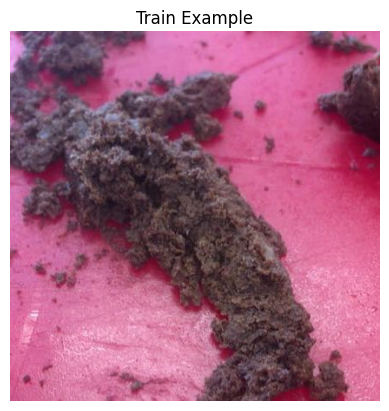

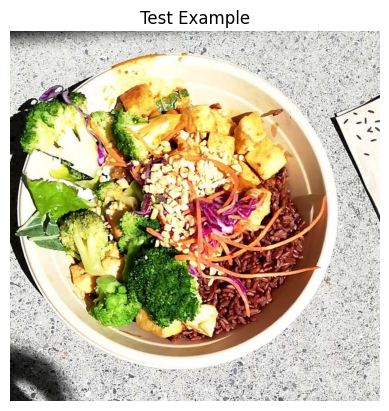

In [6]:
# Train image
img_path = '/kaggle/input/food-data/images_train/006316.jpg'
img = Image.open(img_path).convert('RGB')  # Convert to RGB
plt.imshow(img)
plt.title("Train Example")
plt.axis('off')
plt.show()

# Test image
img_path = '/kaggle/input/food-data/images_test/101975.jpg'
img = Image.open(img_path).convert('RGB')  # Convert to RGB
plt.imshow(img)
plt.title("Test Example")
plt.axis('off')
plt.show()


# Basic Preprocessing

In [7]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img
transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

# Making Datasets

In [8]:
traindataset = FoodOneHotDataset(
    img_dir="/kaggle/input/food-data/images_train",
    label_csv="/kaggle/input/food-data/train_onehot.csv",
    transform=transform
)

testdataset = TestDataset("/kaggle/input/food-data/images_test", transform=transform)

# Labels Csv

In [9]:
df=pd.read_csv("/kaggle/input/food-data/train_onehot.csv")
df

,Filename,0,1,2,3,4,5,6,7,8,...,488,489,490,491,492,493,494,495,496,497
0,131094.jpg,1,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,131097.jpg,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,131098.jpg,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,131100.jpg,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,131101.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39957,131017.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39958,131021.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39959,131053.jpg,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39960,131066.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Finding number of classes

In [10]:
categories = pd.read_csv('/kaggle/input/food-data/categories_new.csv')
classes = categories['name'].tolist()
print("Classes:", classes)
print(f"That's {len(classes)} classes")

Classes: ['bread-wholemeal', 'jam', 'water', 'bread-sourdough', 'banana', 'soft-cheese', 'ham-raw', 'hard-cheese', 'cottage-cheese', 'bread-half-white', 'coffee-with-caffeine', 'fruit-salad', 'pancakes', 'tea', 'salmon-smoked', 'avocado', 'spring-onion-scallion', 'ristretto-with-caffeine', 'ham', 'egg', 'bacon-frying', 'chips-french-fries', 'juice-apple', 'chicken', 'tomato-raw', 'broccoli', 'shrimp-boiled', 'beetroot-steamed-without-addition-of-salt', 'carrot-raw', 'chickpeas', 'french-salad-dressing', 'pasta-hornli', 'sauce-cream', 'meat-balls', 'pasta', 'tomato-sauce', 'cheese', 'pear', 'cashew-nut', 'almonds', 'lentils', 'mixed-vegetables', 'peanut-butter', 'apple', 'blueberries', 'cucumber', 'cocoa-powder', 'greek-yaourt-yahourt-yogourt-ou-yoghourt', 'maple-syrup-concentrate', 'buckwheat-grain-peeled', 'butter', 'herbal-tea', 'mayonnaise', 'soup-vegetable', 'wine-red', 'wine-white', 'green-bean-steamed-without-addition-of-salt', 'sausage', 'pizza-margherita-baked', 'salami', 'mush

# Making Loaders

In [11]:
batch_size = 32
train_dataset_loader = DataLoader(traindataset, batch_size=batch_size)
test_dataset_loader = DataLoader(testdataset, batch_size=batch_size)

# Calculating the mean and standard deviation of datasets

In [ ]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std
    

In [ ]:
#for train
mean, std = get_mean_std(train_dataset_loader)
print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

#for test
mean2, std2 = get_mean_std(test_dataset_loader)
print(f"Mean: {mean2}")
print(f"Standard deviation: {std2}")

Mean: tensor([0.5944, 0.5082, 0.4259])
Standard deviation: tensor([0.2499, 0.2538, 0.2682])
Mean: tensor([0.5973, 0.5101, 0.4262])
Standard deviation: tensor([0.2477, 0.2509, 0.2629])

# Normalization  according to the mean and std

In [12]:
mean=[0.5944, 0.5082, 0.4259]
std=[0.2499, 0.2538, 0.2682]
mean2=[0.5973, 0.5101, 0.4262]
std2=[0.2477, 0.2509, 0.2629]
transform_norm = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize(256),             
    transforms.CenterCrop(224),         
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(
        degrees=15,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05),
        shear=10
    ),
    transforms.ColorJitter(contrast=0.3, brightness=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
transform_norm1 = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean2, std=std2)
])


# Normalized Datasets

In [13]:
norm_dataset =FoodOneHotDataset(
    img_dir="/kaggle/input/food-data/images_train",
    label_csv="/kaggle/input/food-data/train_onehot.csv",
    transform=transform_norm
)

test_norm_dataset =TestDataset("/kaggle/input/food-data/images_test", transform=transform_norm1)



# Splitting data into validation and training

In [14]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

val_size = int(0.2 * len(norm_dataset))
train_size = len(norm_dataset) - val_size

train_dataset, val_dataset = random_split(norm_dataset, [train_size, val_size],generator=g)

length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(norm_dataset)
percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.0% of full data
Validation data is 20.0% of full data


# Loaders

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)

data_loader=DataLoader(norm_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_norm_dataset, batch_size=batch_size,shuffle=False)

# Calculating class distributions

In [16]:
def class_counts(dataset, class_names):
    """
    Counts class distribution in a dataset with one-hot encoded labels.
    
    Parameters:
        dataset: FoodOneHotDataset instance
        class_names: list of class names in the correct index order
    
    Returns:
        pd.Series with counts per class name
    """
    label_indices = [torch.argmax(label).item() for _, label in tqdm(dataset, desc="Counting classes")]
    count = Counter(label_indices)
    return pd.Series({class_names[i]: count.get(i, 0) for i in range(len(class_names))})

In [17]:
train_class_distributions = class_counts(train_dataset, classes)
val_class_distributions = class_counts(val_dataset, classes)

print('Train class Distribution:',train_class_distributions)
print('Validation class Distribution:',val_class_distributions)

Counting classes:   0%|          | 0/31970 [00:00<?, ?it/s]

Counting classes:   0%|          | 0/7992 [00:00<?, ?it/s]

Train class Distribution: bread-wholemeal                                                   1173
jam                                                                421
water                                                             2301
bread-sourdough                                                    136
banana                                                             502
                                                                  ... 
white-asparagus                                                     12
pie-rhubarb-baked-with-cake-dough                                   12
tomato-stewed-without-addition-of-fat-without-addition-of-salt       2
cherries                                                            30
nectarine                                                           77
Length: 498, dtype: int64
Validation class Distribution: bread-wholemeal                                                   279
jam                                                               

# Bar charts of class distirbutions

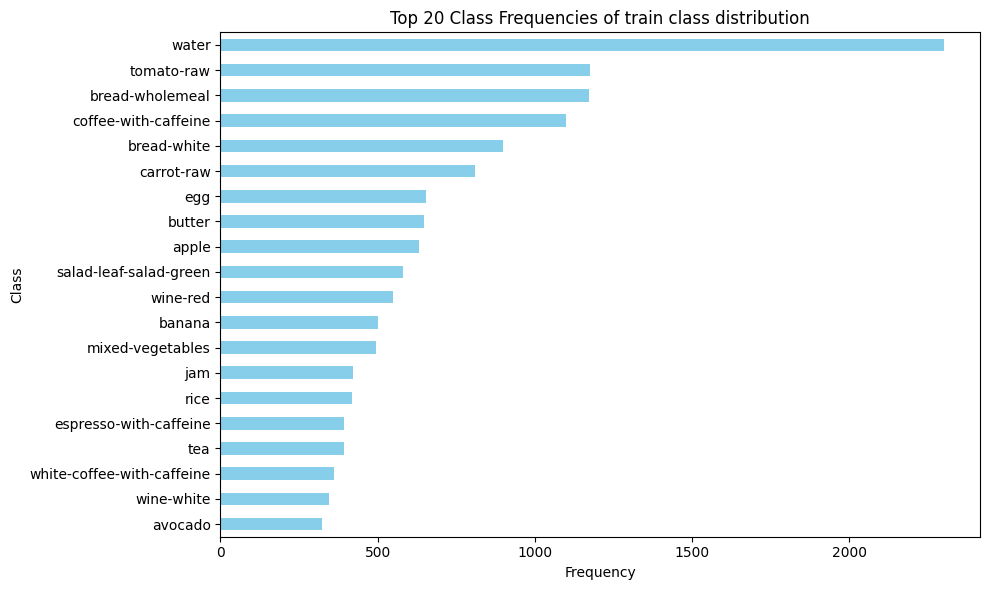

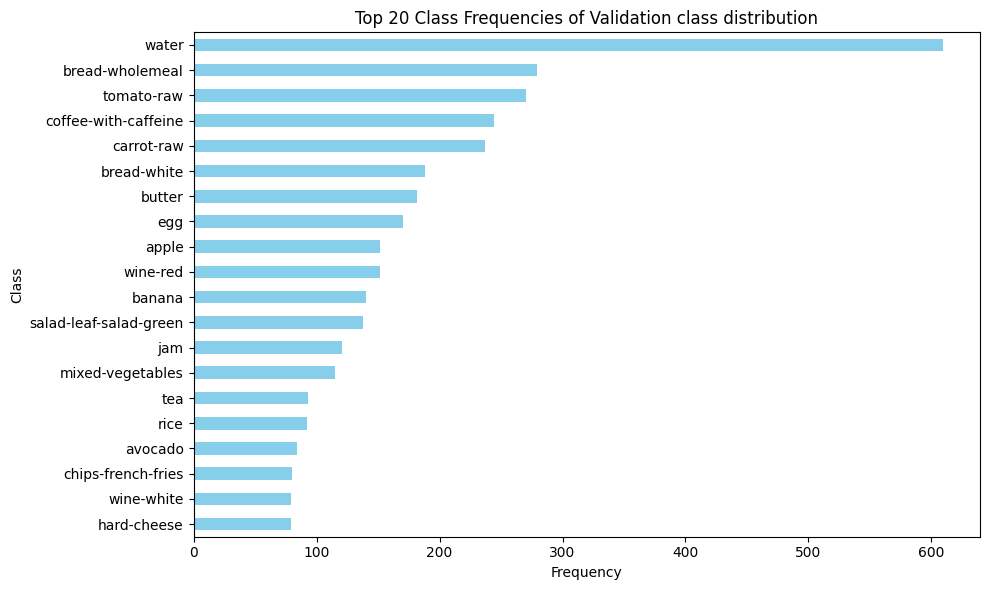

In [18]:
top_n = 20
top_classes = train_class_distributions.sort_values(ascending=False).head(top_n)
plt.figure(figsize=(10, 6))
top_classes.plot(kind='barh', color='skyblue')
plt.title(f"Top {top_n} Class Frequencies of train class distribution")
plt.xlabel("Frequency")
plt.ylabel("Class")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

top_classes = val_class_distributions.sort_values(ascending=False).head(top_n)
plt.figure(figsize=(10, 6))
top_classes.plot(kind='barh', color='skyblue')
plt.title(f"Top {top_n} Class Frequencies of Validation class distribution")
plt.xlabel("Frequency")
plt.ylabel("Class")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


#  Model

In [19]:
model_seq = torch.nn.Sequential()

# Block 1: First convolutional block
conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1)  # Increased to 32
model_seq.append(conv1)
model_seq.append(torch.nn.ReLU())
model_seq.append(torch.nn.BatchNorm2d(32))  # BatchNorm after activation
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model_seq.append(max_pool1)

# Block 2: Second convolutional block
conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)  
model_seq.append(conv2)
model_seq.append(torch.nn.ReLU())
model_seq.append(torch.nn.BatchNorm2d(64))  # BatchNorm
max_pool2 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model_seq.append(max_pool2)
model_seq.append(torch.nn.Dropout2d(0.25))  # Add dropout for regularization

# Block 3: Third convolutional block
conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1)  # Increased to 128
model_seq.append(conv3)
model_seq.append(torch.nn.ReLU())
model_seq.append(torch.nn.BatchNorm2d(128))  # BatchNorm
max_pool3 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model_seq.append(max_pool3)

# Block 4: Fourth convolutional block (add more depth)
conv4 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1)
model_seq.append(conv4)
model_seq.append(torch.nn.ReLU())
model_seq.append(torch.nn.BatchNorm2d(256))
model_seq.append(torch.nn.Dropout2d(0.3))

# Block 5: Fifth convolutional block
conv5 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1)
model_seq.append(conv5)
model_seq.append(torch.nn.ReLU())
model_seq.append(torch.nn.BatchNorm2d(512))
model_seq.append(torch.nn.Dropout2d(0.4))

# Global Average Pooling (better than flatten for reducing parameters)
model_seq.append(torch.nn.AdaptiveAvgPool2d((1, 1)))
model_seq.append(torch.nn.Flatten())

# Fully connected layers
model_seq.append(torch.nn.Dropout(0.5))
model_seq.append(torch.nn.Linear(512, 1024))
model_seq.append(torch.nn.ReLU())
model_seq.append(torch.nn.BatchNorm1d(1024))

model_seq.append(torch.nn.Dropout(0.3))
model_seq.append(torch.nn.Linear(1024, 512))
model_seq.append(torch.nn.ReLU())
model_seq.append(torch.nn.BatchNorm1d(512))

model_seq.append(torch.nn.Dropout(0.2))
model_seq.append(torch.nn.Linear(512, 498))  # 498 food categories




Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Dropout2d(p=0.25, inplace=False)
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU()
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

# Loss Function ,optimizers and  sheduler

In [20]:
all_labels = [train_dataset[i][1].numpy() for i in range(len(train_dataset))]
all_labels = np.stack(all_labels)

# Count per class
total_pos = all_labels.sum(axis=0) + 1e-5  # avoid division by zero
total_neg = len(all_labels) - total_pos
pos_weight = torch.tensor(total_neg / total_pos, dtype=torch.float32)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = torch.optim.Adam(model_seq.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',         # Minimize validation loss
    factor=0.5,         # Reduce LR by half
    patience=5,         # Wait 5 epochs
    verbose=True,       # Print when LR changes
    min_lr=1e-7         # Minimum LR
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Moving model to cuda

In [21]:
model = model_seq.to(device)

# Model Arictecture

In [22]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
              ReLU-6         [-1, 64, 112, 112]               0
       BatchNorm2d-7         [-1, 64, 112, 112]             128
         MaxPool2d-8           [-1, 64, 56, 56]               0
         Dropout2d-9           [-1, 64, 56, 56]               0
           Conv2d-10          [-1, 128, 56, 56]          73,856
             ReLU-11          [-1, 128, 56, 56]               0
      BatchNorm2d-12          [-1, 128, 56, 56]             256
        MaxPool2d-13          [-1, 128, 28, 28]               0
           Conv2d-14          [-1, 256,

Since working on a multi-label classification task — not multi-class.
One image might be both Pizza and Tomato_Sauce, so the output is a 498-dimensional vector of 0s and 1s.

# Train the model on 10 epochs

In [23]:
def train(model, train_loader, optimizer, criterion, device="cuda"):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device).float()  # Ensure labels are float for BCEWithLogitsLoss

        optimizer.zero_grad()
        outputs = model(inputs)  # No sigmoid here
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss
def score(model, val_loader, criterion, threshold=0.1, device="cuda"):
    model.eval()
    all_outputs = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)  # raw logits
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs) > threshold  # apply threshold
            all_outputs.append(preds.cpu())
            all_labels.append(labels.cpu())

    # Concatenate predictions and labels
    all_outputs = torch.cat(all_outputs, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    f1 = f1_score(all_labels, all_outputs, average="samples")
    precision = precision_score(all_labels, all_outputs, average="samples")
    recall = recall_score(all_labels, all_outputs, average="samples")
    avg_loss = total_loss / len(val_loader.dataset)

    return avg_loss, f1, precision, recall


In [24]:
train_losses = []
val_losses = []
f1_scores = []
precisions = []
recalls = []
lrs = []

num_epochs = 10
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, f1, precision, recall = score(model, val_loader, criterion, device=device)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")
    
    scheduler.step(val_loss)
    
    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    lrs.append(scheduler.get_last_lr()[0])



Epoch 1/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.4690
Val Loss: 1.4657 | F1: 0.0078 | Precision: 0.0039 | Recall: 0.9760
Current LR: 0.001000

Epoch 2/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.3896
Val Loss: 1.3685 | F1: 0.0082 | Precision: 0.0041 | Recall: 0.9813
Current LR: 0.001000

Epoch 3/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.2848
Val Loss: 1.2654 | F1: 0.0079 | Precision: 0.0040 | Recall: 0.9894
Current LR: 0.001000

Epoch 4/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.2300
Val Loss: 1.2403 | F1: 0.0079 | Precision: 0.0040 | Recall: 0.9909
Current LR: 0.001000

Epoch 5/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.1712
Val Loss: 1.2053 | F1: 0.0082 | Precision: 0.0041 | Recall: 0.9916
Current LR: 0.001000

Epoch 6/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.1456
Val Loss: 1.1936 | F1: 0.0083 | Precision: 0.0042 | Recall: 0.9913
Current LR: 0.001000

Epoch 7/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.1283
Val Loss: 1.1548 | F1: 0.0088 | Precision: 0.0044 | Recall: 0.9885
Current LR: 0.001000

Epoch 8/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.1159
Val Loss: 1.1545 | F1: 0.0085 | Precision: 0.0043 | Recall: 0.9899
Current LR: 0.001000

Epoch 9/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.1061
Val Loss: 1.1739 | F1: 0.0083 | Precision: 0.0042 | Recall: 0.9915
Current LR: 0.001000

Epoch 10/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.0930
Val Loss: 1.1614 | F1: 0.0083 | Precision: 0.0042 | Recall: 0.9918
Current LR: 0.001000


# Training and validation curves.

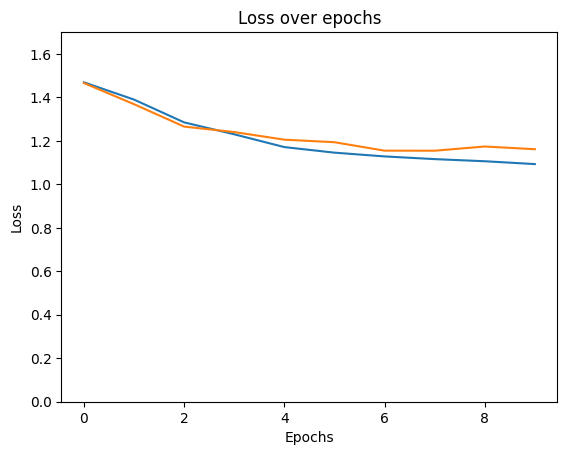

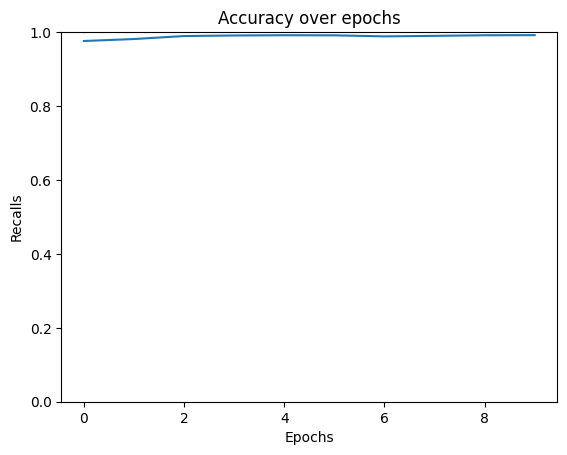

In [30]:
epochs = list(range(1, 11))

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses  , label="Validation Loss")
plt.ylim([0, 1.7])
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
plt.plot( recalls, label="Recall")
plt.plot(epochs, label="Epochs")
plt.ylim([0, 1])
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Recalls")
plt.show()


# Prediction

In [31]:
def predict(model, data_loader, threshold=0.5, device="cuda"):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for inputs, _ in tqdm(data_loader, desc="Predicting"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()
            all_preds.append(preds.cpu())

    return torch.cat(all_preds, dim=0)

test_preds = predict(model, test_loader, threshold=0.5, device=device)

Predicting:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
filenames = []
for _, name in test_loader:
    filenames.extend(name)  # collect filenames from DataLoader

# 2. Ensure predictions and filenames match
assert len(test_preds) == len(filenames)

# 3. Convert predictions to numpy
predictions_np = test_preds.numpy().astype(int)

# 4. Build DataFrame
df = pd.DataFrame(predictions_np)
df.insert(0, 'Filename', filenames)  # insert filenames as first column

# 5. Save to CSV
df.to_csv("multi_label_predictions.csv", index=False)
print("✅ Predictions saved to 'multi_label_predictions.csv'")


# MobileNet Model

In [41]:
model = EfficientNet.from_pretrained('efficientnet-b4')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 119MB/s] 


Loaded pretrained weights for efficientnet-b4


setting last layer for 2 labels only

In [42]:
num_classes=498
model._fc = nn.Linear(model._fc.in_features, num_classes)

# Model Arcitecture

In [45]:


summary(model, input_size=(3, 224, 224))  # Example for RGB image


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 48, 112, 112]           1,296
       BatchNorm2d-3         [-1, 48, 112, 112]              96
MemoryEfficientSwish-4         [-1, 48, 112, 112]               0
         ZeroPad2d-5         [-1, 48, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 48, 112, 112]             432
       BatchNorm2d-7         [-1, 48, 112, 112]              96
MemoryEfficientSwish-8         [-1, 48, 112, 112]               0
          Identity-9             [-1, 48, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 12, 1, 1]             588
MemoryEfficientSwish-11             [-1, 12, 1, 1]               0
         Identity-12             [-1, 12, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 48, 1, 1]             624
         I

load the model on the gpu

In [ ]:
model = model.to(device)

# loss function and optimizer and shedular for mobilenet

In [46]:
all_labels = [train_dataset[i][1].numpy() for i in range(len(train_dataset))]
all_labels = np.stack(all_labels)

# Count per class
total_pos = all_labels.sum(axis=0) + 1e-5  # avoid division by zero
total_neg = len(all_labels) - total_pos
pos_weight = torch.tensor(total_neg / total_pos, dtype=torch.float32)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = torch.optim.Adam(model_seq.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',         # Minimize validation loss
    factor=0.5,         # Reduce LR by half
    patience=5,         # Wait 5 epochs
    verbose=True,       # Print when LR changes
    min_lr=1e-7         # Minimum LR
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Training the model

In [47]:
train_losses = []
val_losses = []
f1_scores = []
precisions = []
recalls = []
lrs = []

num_epochs = 10
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, f1, precision, recall = score(model, val_loader, criterion, device=device)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")
    
    scheduler.step(val_loss)
    
    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    lrs.append(scheduler.get_last_lr()[0])



Epoch 1/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.3914
Val Loss: 1.4189 | F1: 0.0071 | Precision: 0.0035 | Recall: 1.0000
Current LR: 0.001000

Epoch 2/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.3915
Val Loss: 1.4180 | F1: 0.0071 | Precision: 0.0035 | Recall: 1.0000
Current LR: 0.001000

Epoch 3/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.3902
Val Loss: 1.4183 | F1: 0.0071 | Precision: 0.0035 | Recall: 1.0000
Current LR: 0.001000

Epoch 4/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.3915
Val Loss: 1.4178 | F1: 0.0071 | Precision: 0.0035 | Recall: 1.0000
Current LR: 0.001000

Epoch 5/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.3920
Val Loss: 1.4178 | F1: 0.0071 | Precision: 0.0035 | Recall: 1.0000
Current LR: 0.001000

Epoch 6/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.3914
Val Loss: 1.4186 | F1: 0.0071 | Precision: 0.0035 | Recall: 1.0000
Current LR: 0.001000

Epoch 7/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.3919
Val Loss: 1.4187 | F1: 0.0071 | Precision: 0.0035 | Recall: 1.0000
Current LR: 0.001000

Epoch 8/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.3928
Val Loss: 1.4176 | F1: 0.0071 | Precision: 0.0035 | Recall: 1.0000
Current LR: 0.001000

Epoch 9/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.3909
Val Loss: 1.4180 | F1: 0.0071 | Precision: 0.0035 | Recall: 1.0000
Current LR: 0.001000

Epoch 10/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.3909
Val Loss: 1.4192 | F1: 0.0071 | Precision: 0.0035 | Recall: 1.0000
Current LR: 0.001000


# Training and validation curves

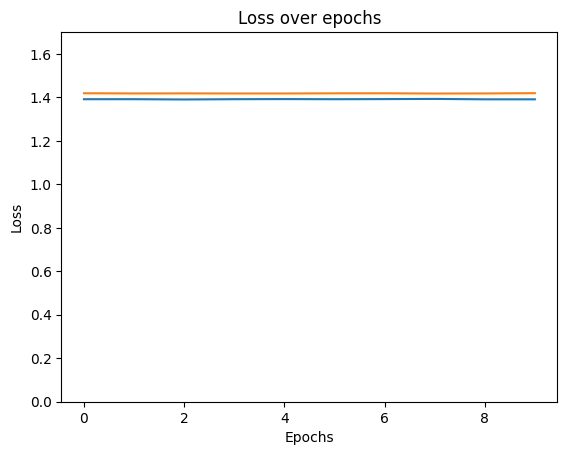

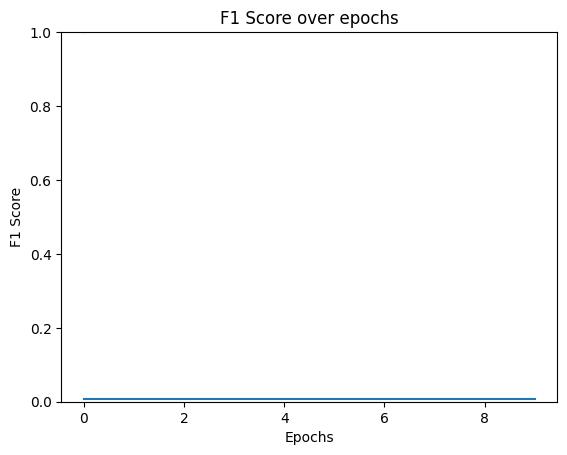

In [49]:
epochs = list(range(1, 11))

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses  , label="Validation Loss")
plt.ylim([0, 1.7])
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
plt.plot( f1_scores, label="F 1 score")
plt.plot(epochs, label="Epochs")
plt.ylim([0, 1])
plt.title("F1 Score over epochs")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.show()


# Predictions

In [51]:
predictions_val = predict(model, test_loader, threshold=0.5, device=device)
print(predictions_val)

Predicting:   0%|          | 0/32 [00:00<?, ?it/s]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 1.]])


In [53]:

filenames = []
for _, name in test_loader:
    filenames.extend(name)  # collect filenames from DataLoader

# 2. Ensure predictions and filenames match
assert len(test_preds) == len(filenames)

# 3. Convert predictions to numpy
predictions_np = predictions_val.numpy().astype(int)

# 4. Build DataFrame
df = pd.DataFrame(predictions_np)
df.insert(0, 'Filename', filenames)  # insert filenames as first column

# 5. Save to CSV
df.to_csv("multi_label_predictions1.csv", index=False)
print("✅ Predictions saved to 'multi_label_predictions1.csv'")


✅ Predictions saved to 'multi_label_predictions.csv'
